In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_PINN_int import *
from NN_library.train_dual_PINN_int import *
from matplotlib.tri import Triangulation
from utility import *
from PDE_losses import PDE_loss, PDE_loss_dual
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_grid(129, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 129**2)

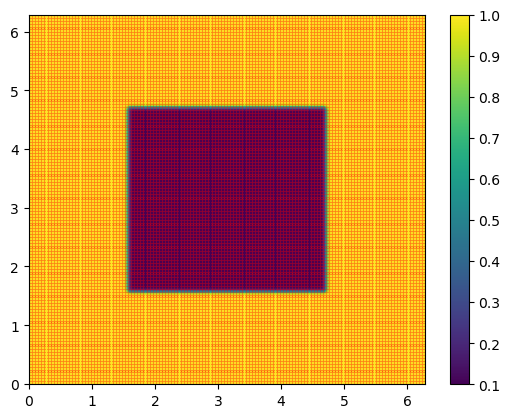

In [3]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

eps = 30
def a_function(x,y):
    x_dir = 0.5 + 0.5*np.tanh(eps*np.sin(x-np.pi/2))
    y_dir = 0.5 + 0.5*np.tanh(eps*np.sin(y-np.pi/2))
    a = 1 - 0.9*x_dir*y_dir
    return a

def A_interp(x): 
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a.view(-1,1,1) * I
    return A

def A_interp_inv(x):  
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = 1/a.view(-1,1,1) * I
    return A

def A(x):  
    x = x - torch.pi/2
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1.).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    x = x - torch.pi/2
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1.).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

# Primal PINN

In [5]:
net_primal = PINN(n_periodic=5, n_hidden=10, n_layers=2, period_len=L)
total_params = sum(p.numel() for p in net_primal.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/PINN_primal_{eps}_{total_params}'}

Number of parameters: 391


In [7]:
net_primal = load_network(net_primal, args['name']+'_39999', args)
net_primal = net_primal.to(dev)

In [6]:
losses_train, losses_val = train_primal(net_primal, loaders, args, A_interp, H1, L)

Epoch: 0 mean train loss:  5.83064423e+01, bound:  7.85862505e-01
Epoch: 1 mean train loss:  5.82752304e+01, bound:  7.85835385e-01
Epoch: 2 mean train loss:  5.82442207e+01, bound:  7.85808623e-01
Epoch: 3 mean train loss:  5.82134094e+01, bound:  7.85782516e-01
Epoch: 4 mean train loss:  5.81827927e+01, bound:  7.85757363e-01
Epoch: 5 mean train loss:  5.81523743e+01, bound:  7.85733104e-01
Epoch: 6 mean train loss:  5.81221428e+01, bound:  7.85710156e-01
Epoch: 7 mean train loss:  5.80921097e+01, bound:  7.85688221e-01
Epoch: 8 mean train loss:  5.80622559e+01, bound:  7.85667539e-01
Epoch: 9 mean train loss:  5.80325813e+01, bound:  7.85648108e-01
Epoch: 10 mean train loss:  5.80030861e+01, bound:  7.85629869e-01
Epoch: 11 mean train loss:  5.79737473e+01, bound:  7.85612822e-01
Epoch: 12 mean train loss:  5.79445763e+01, bound:  7.85596967e-01
Epoch: 13 mean train loss:  5.79155540e+01, bound:  7.85582304e-01
Epoch: 14 mean train loss:  5.78866768e+01, bound:  7.85568953e-01
Epoch

In [7]:
np.save(f'NN_library/training_data/square/PINN_primal_{eps}_{total_params}', np.vstack([losses_train, losses_val]))

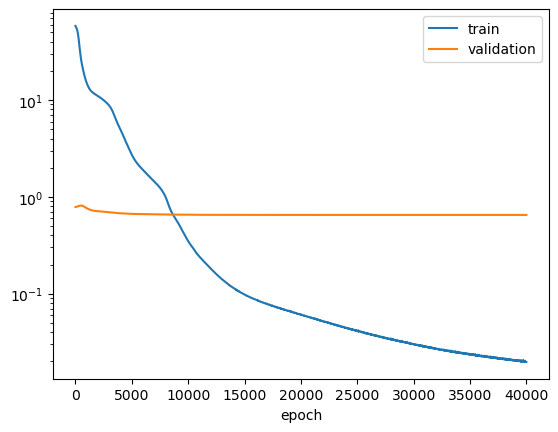

In [8]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [9]:
U1 = net_primal(grid_data).detach().cpu()
error_1, _, _ = PDE_loss(grid_data, net_primal, A_interp, H1)
error_2, _, _ = PDE_loss(grid_data, net_primal, A, H1)

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos3, ax=axs[2])

In [9]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])
x_rot = torch.fliplr(x)

_, q1, gH = PDE_loss(x, net_primal, A_interp, H1)
bound_1 = compute_estimate(areas, tri, q1, gH, L).detach().item()
print(bound_1)

U1 = net_primal(x)
U2 = net_primal(x_rot)

bound_2 = compute_bound_primal(U1, U2, tri, x, A, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_u_PINN_{total_params}_{eps}.npy', (bound_1, bound_2))

0.6505584120750427
0.6491661830809871


# Dual PINN

In [10]:
net_dual = PINN(n_periodic=5, n_hidden=10, n_layers=2, period_len=L)
total_params = sum(p.numel() for p in net_dual.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/PINN/square/PINN_dual_{eps}_{total_params}'}

Number of parameters: 391


In [11]:
net_dual = load_network(net_dual, args['name']+'_39999', args)
net_dual = net_dual.to(dev)

In [11]:
losses_train, losses_val = train_dual(net_dual, loaders, args, A_interp_inv, H1, L)

Epoch: 0 mean train loss:  5.78370850e+03, bound:  2.82973528e-01
Epoch: 1 mean train loss:  5.75426514e+03, bound:  2.82993823e-01
Epoch: 2 mean train loss:  5.72496338e+03, bound:  2.83018202e-01
Epoch: 3 mean train loss:  5.69581250e+03, bound:  2.83046454e-01
Epoch: 4 mean train loss:  5.66682275e+03, bound:  2.83078551e-01
Epoch: 5 mean train loss:  5.63800293e+03, bound:  2.83114433e-01
Epoch: 6 mean train loss:  5.60936328e+03, bound:  2.83153892e-01
Epoch: 7 mean train loss:  5.58091016e+03, bound:  2.83196896e-01
Epoch: 8 mean train loss:  5.55265332e+03, bound:  2.83243328e-01
Epoch: 9 mean train loss:  5.52460156e+03, bound:  2.83293068e-01
Epoch: 10 mean train loss:  5.49676123e+03, bound:  2.83346146e-01
Epoch: 11 mean train loss:  5.46914062e+03, bound:  2.83402354e-01
Epoch: 12 mean train loss:  5.44174658e+03, bound:  2.83461630e-01
Epoch: 13 mean train loss:  5.41458594e+03, bound:  2.83523887e-01
Epoch: 14 mean train loss:  5.38766309e+03, bound:  2.83588976e-01
Epoch

In [12]:
np.save(f'NN_library/training_data/square/PINN_dual_{eps}_{total_params}', np.vstack([losses_train, losses_val]))

In [13]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [16]:
W1 = net_dual(grid_data).detach().cpu()
error_1, _, _ = PDE_loss_dual(grid_data, net_dual, A_interp_inv, H1)
error_2, _, _ = PDE_loss_dual(grid_data, net_dual, A_inv, H1)

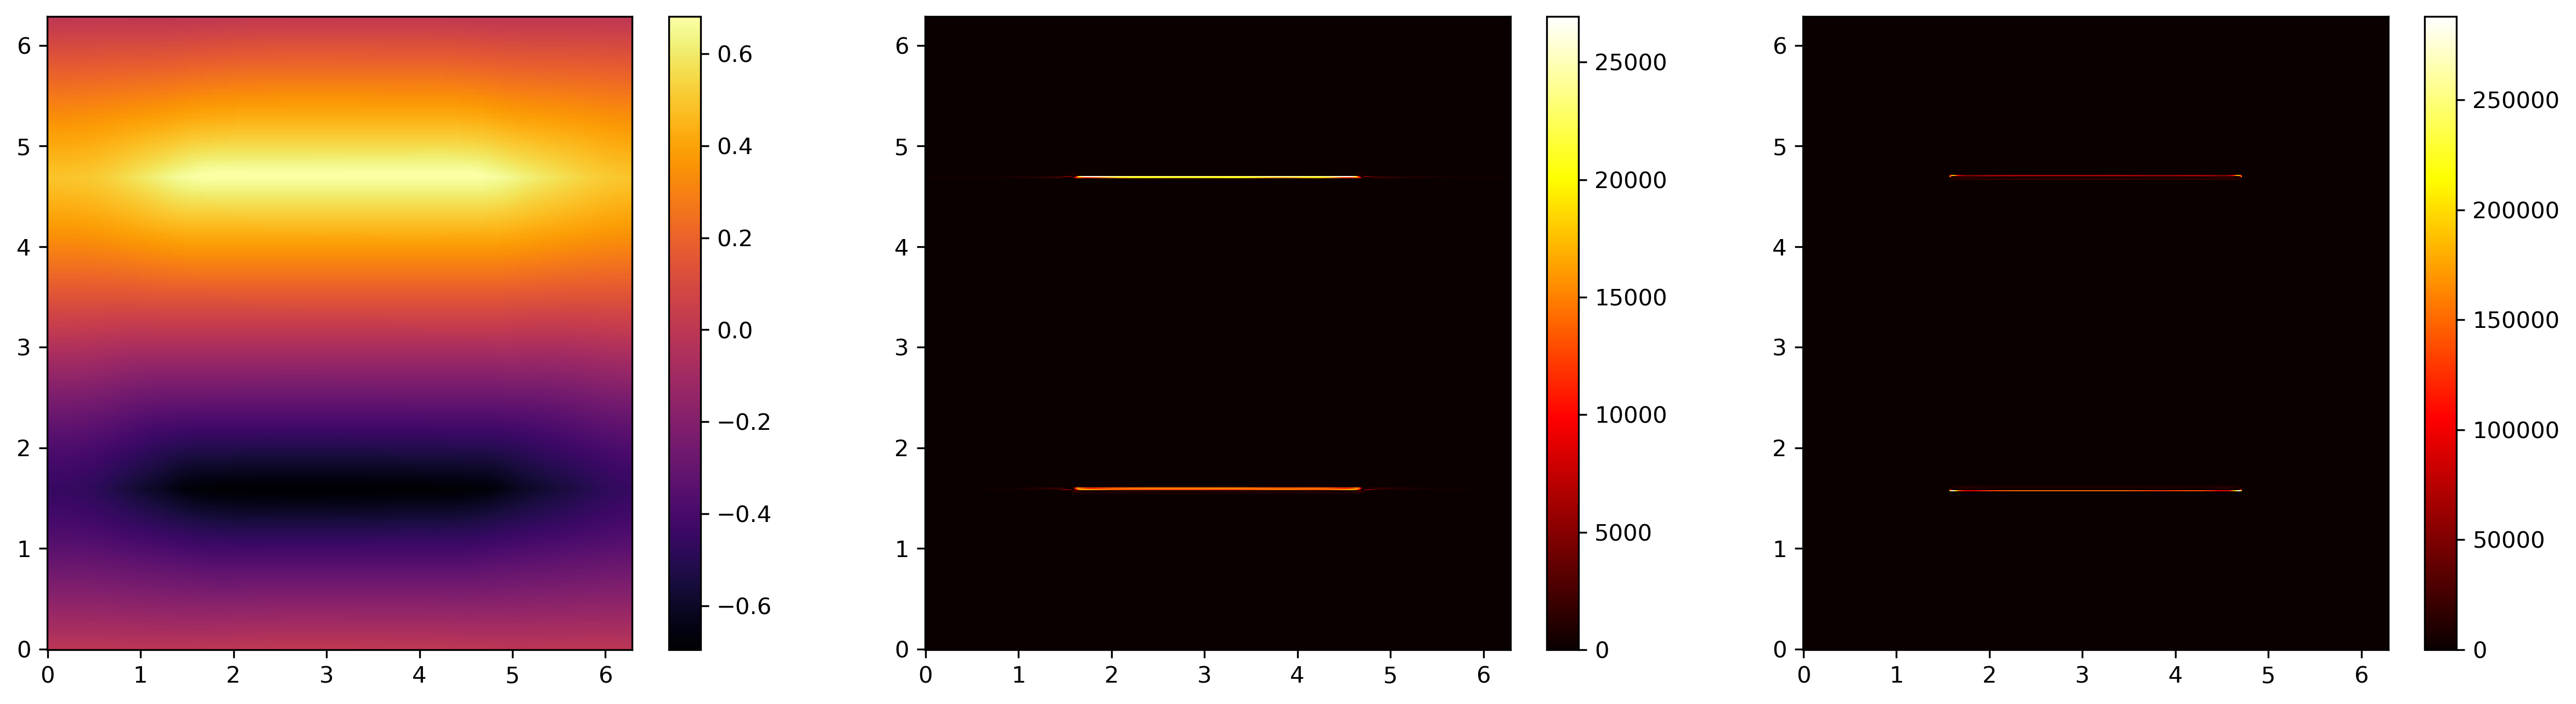

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], W1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='hot')
fig.colorbar(pos3, ax=axs[2])

In [14]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])
x_rot = torch.fliplr(x)
x_rot[:,1] = -x_rot[:,1]

_, q2, gH = PDE_loss_dual(x, net_dual, A_interp_inv, H1)
bound_1 = compute_estimate(areas, tri, q2, gH, L).detach().item()
print(1/bound_1)

W1 = net_dual(x)
W2 = net_dual(x_rot)

bound_2 = compute_bound_dual(W1, W2, tri, x, A_inv, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_l_PINN_{total_params}_{eps}.npy', (1/bound_1, bound_2))

0.5995456276686977
0.5958351577011868
